In [83]:
import pandas as pd
import csv
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk import ngrams
from nltk.stem import WordNetLemmatizer

In [84]:
data = pd.read_csv('publ.csv')
data.sample(3)

<ipython-input-84-47bcf7cd181f>:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('publ.csv')


,publ_id,publ_name,year,doi,annotation,geo_name,collect_name,collect_type,author_affs,author_ids
84937,1052922,Electrodynamic control for spacecraft attitude...,2014,https://doi.org/10.1134/s001095251406001x,NaN,NaN,NaN,NaN,St Petersburg University,1012698; 1012697
5455,5471,Нестандартное оборудование для расфасовки жидк...,2009,NaN,В докладе рассматривается проблема создания от...,Москва,NaN,NaN,NaN,357; 922; 955; 1074
26763,27265,Stochastic Dissipativity with Risk-Sensitive S...,2009,NaN,NaN,Кумамото,NaN,NaN,NaN,890; 1443


**Описание признаков:**

publ_id	- Уникальный идентификатор публикации.

year -	Год публикации.

doi	- Digital Object Identifier Уникальный идентификатор для электронных документов.

annotation -	Аннотация или краткое содержание публикации. Это текстовое поле может содержать основные идеи или выводы работы.

geo_name -	Географическое название, связанное с публикацией.

collect_name -	Название коллекции, к которой принадлежит публикация.

collect_type -	Тип коллекции, например, журнал, конференция, книга и т.д. Это помогает классифицировать тип публикации.

author_affs	- Аффилиации авторов.

author_ids - Идентификаторы авторов.

Часть признаков не нужны в исследовании, поэтому удалим их.

In [85]:
data = data.drop(['doi','collect_name','author_affs','author_ids'], axis=1)

Посмотрим содержание пустых строк в датасете

<Axes: >

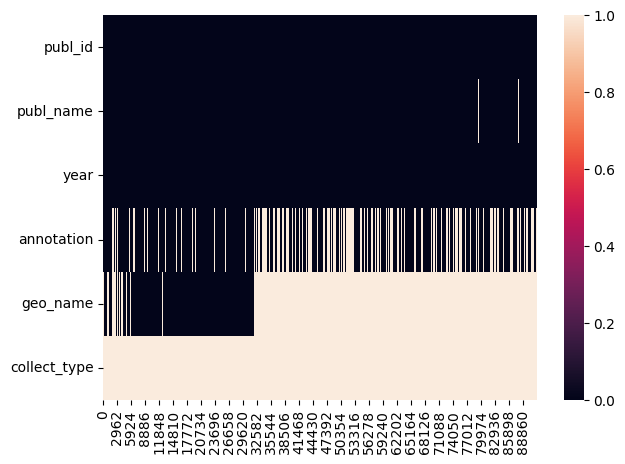

In [86]:
plt.figure(figsize=(7,5))
sns.heatmap(data.isna().transpose())

Видим, что много пустых значений в geo_name и collect_type, поэтому также удалим эти столбцы. Дополнительно удалим строки не содержашие аннотации и название публикации.

In [87]:
data = data.drop(['geo_name','collect_type'], axis=1)

In [88]:
data = data.dropna()

Разделим датасет на два: статьи на русском и английском языках. Для этого создадим дополнительный признак, содержащий информацию о языке.

In [89]:
def is_russian(text):
    return bool(re.search(r'[а-яА-Я]', text))

In [90]:
data['language'] = data['publ_name'].apply(lambda x: 'ru' if is_russian(x) else 'en')

data_ru = data[data['language'] == 'ru']
data_en = data[data['language'] == 'en']

In [91]:
data_ru.shape

(23483, 5)

In [92]:
data_en.shape

(42410, 5)

In [93]:
data_ru # название и аннотация на разных языках...

,publ_id,publ_name,year,annotation,language
0,1,Методы и средства волнового фитоуправления в б...,2005,Рассматриваются методы и средства волнового фи...,ru
1,2,Метод динамической компенсации в задаче оценив...,2005,В докладе рассматривается задача стабилизации ...,ru
2,3,Управление электромеханическими системами в ус...,2005,Рассматривается задача управления угловым поло...,ru
4,5,Задача стабилизации линейных систем с сигмоида...,2005,Предложена декомпозиционная процедура синтеза ...,ru
5,6,Скользящий электропривод постоянного тока,2005,В работе рассмотрена задача позиционирования д...,ru
...,...,...,...,...,...
91632,1059617,Особенности движения шагающей машины с поворот...,2013,Kinematics mathematical model of walking machi...,ru
91633,1059618,Экспериментальные исследования знакопеременног...,2011,Such operating mode of deep-well pump installa...,ru
91695,1059680,СинтеЗ классификатороВ дифференциальноЙ дИагно...,2011,In the paper classifiers for light form of coa...,ru
91701,1059686,Адаптивная система классификаторов МГУА,2014,"It is shown that the self-organization models,...",ru


Найдем самые популярные темы исследования для определения целевой функции. Это можно сделать частотным методом, выбрав самые встречающиеся темы из названия статей.

In [94]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    words = nltk.word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

In [95]:
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
stop_words = set(stopwords.words('russian'))
lemmatizer = WordNetLemmatizer()

In [96]:
titles = data_ru['publ_name']

processed_titles = titles.apply(preprocess_text)

all_words = ' '.join(processed_titles).split()

bigrams = ngrams(all_words, 2)
bigram_counts = Counter(bigrams)

most_common_bigrams = bigram_counts.most_common(10)
print("Самые популярные темы исследования:")
for bigram, count in most_common_bigrams:
    print(f"{' '.join(bigram)}: {count}")

Самые популярные темы исследования:
систем управления: 291
системы управления: 256
принятия решений: 193
летательных аппаратов: 129
инновационного развития: 120
российской федерации: 116
сложных систем: 110
системах управления: 109
динамических систем: 107
решения задач: 106


In [99]:
bigrams = ngrams(all_words, 3)
bigram_counts = Counter(bigrams)

most_common_bigrams = bigram_counts.most_common(10)
print("Самые популярные темы исследования:")
for bigram, count in most_common_bigrams:
    print(f"{' '.join(bigram)}: {count}")

Самые популярные темы исследования:
поддержки принятия решений: 82
беспилотных летательных аппаратов: 82
сигнала лучевой артерии: 52
пульсового сигнала лучевой: 51
асу тп аэс: 49
параллельных вычислительных системах: 46
управляющих параллельных вычислительных: 44
развитием крупномасштабных систем: 38
сложных технических систем: 36
лекции математике т: 32


In [100]:
bigrams = ngrams(all_words, 4)
bigram_counts = Counter(bigrams)

most_common_bigrams = bigram_counts.most_common(10)
print("Самые популярные темы исследования:")
for bigram, count in most_common_bigrams:
    print(f"{' '.join(bigram)}: {count}")

Самые популярные темы исследования:
пульсового сигнала лучевой артерии: 51
управления безопасностью сложных систем: 29
уровня асу тп аэс: 27
проблемы управления безопасностью сложных: 27
управление развитием крупномасштабных систем: 25
управляющих параллельных вычислительных системах: 25
системы поддержки принятия решений: 22
объектах искусственной средой обитания: 19
верхнего уровня асу тп: 19
управляющих параллельных вычислительных систем: 19


In [98]:
# Числовые признаки
num_cols = [
    'publ_id',
    'year'
]

# Категориальные признаки
cat_cols = [
    'publ_name',
    'annotation',
    'language'
]

feature_cols = num_cols + cat_cols
target_col = '?'